In [162]:
import os
import random
import requests
import psycopg2
from bs4 import BeautifulSoup
from IPython.display import display, HTML, Image


class ImageStorageAndRetrieval:
    """
    Database fns and helpers  
    """
    username = os.getenv('USER')

    def __init__(self):
        self.connect_to_database()

    def connect_to_database(self):
        password = os.environ.get('POSTGRES_PASSWORD')
        # Check if the password is set
        if password is None:
            raise ValueError("POSTGRES_PASSWORD environment variable is not set.")
        self.conn = psycopg2.connect(
            dbname="jupyter-adsb",
            user="jupyter-admin",
            password=password,
            host="localhost",
            port="5432"
        )
        self.cursor = self.conn.cursor()
        self.create_table_if_not_exists()

    def close_database_connection(self):
        self.cursor.close()
        self.conn.close()

    def create_table_if_not_exists(self):
        
        create_table_query = """
        CREATE TABLE IF NOT EXISTS aircraft_model_to_path (
            model_and_number VARCHAR(255) PRIMARY KEY,
            image_path TEXT
        );
        """
        self.cursor.execute(create_table_query)
        self.conn.commit()

    def store_image_url(self, model_and_number, image_path):
        self.cursor.execute("""
            INSERT INTO aircraft_model_to_path (model_and_number, image_path)
            VALUES (%s, %s)
            ON CONFLICT (model_and_number) DO UPDATE
            SET image_path = EXCLUDED.image_path;
        """, (model_and_number, image_path))
        self.conn.commit()

    def check_file_existence(self, file_path):
        return os.path.exists(file_path)

    def retrieve_image_path(self, model_and_number):
        # Retrieve the image path from the database
        self.cursor.execute("SELECT image_path FROM aircraft_model_to_path WHERE model_and_number = %s", (model_and_number,))
        row = self.cursor.fetchone()

        if row:
            image_path = row[0]
            if self.check_file_existence(image_path):
                # If file exists, return the image path
                return image_path
            else:
                # If file does not exist, delete the entry
                self.cursor.execute("DELETE FROM aircraft_model_to_path WHERE model_and_number = %s", (model_and_number,))
                self.conn.commit()

        # If there is no matching entry or the file does not exist, return None
        return None
    
    """
    Scraping fns and helpers 
    """
    def _planespotters(self, headers, model_and_number):
        # model_and_number for planespotters, whitespace needs to be converted to '-' 
        model_and_number = model_and_number.strip().replace(' ', '-')
        url = f"https://www.planespotters.net/photo/search?reg=&actype=s_{model_and_number}&searchtext=&searchtype=photographer&s=all"
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        image_elements = soup.find_all('img', class_='photo_card__photo')
        if not image_elements[:5]:
                print(Exception("Couldn't find any images in planespotters"))
                return
        return random.choice(image_elements[:5])['src']

    def _google(self, headers, model_and_number):
        url = f"https://www.google.com/search?q={model_and_number}&tbm=isch"
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        image_elements = soup.find_all('img')
        # Select from most relevant (top 5)
        random_image = random.choice(image_elements[1:6])
        src = random_image['src']
        if not src:
            print(Exception("Couldn't find any images in google"))
            return
        # Check if the URL is a full URL or a relative URL
        if src.startswith('/'):
            # If it's a relative URL, construct the full URL correctly
            src = f"https://www.google.com{src}"
            return src
        else:
            return src
    
        
    def get_random_image(self, model_and_number):
        model_and_number = model_and_number.replace(' ', '-').lower()
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
        }
        # need to add self to these when put back in class
        src = self._planespotters(headers, model_and_number)
        if not src:
            src = self._google(headers, model_and_number)
        if not src:
            raise Exception(f"Could not find any images for {model_and_number} in any of our sources")
        return src


    def download_image(self, url, filename):
        response = requests.get(url)
        response.raise_for_status()
        with open(filename, 'wb') as f:
            f.write(response.content)

    """
    Display
    """
    
    def display_image(self, image_url, model_and_number):
        print(model_and_number)
        display(Image(filename=image_url))

    """
    Driver and other high level fns
    """
    def get_or_download_image(self, model_and_number):
        """
        checks postgres to see if we have image path for model and number
        in local storage:
            -if yes:
                returns path/to/image
            -if no:
                creates a .jpg file placeholder in system
                downloads image
                stores @ file path 
        """
        image_path = self.retrieve_image_path(model_and_number)
        if image_path:
            return image_path
        else:
            image_url = self.get_random_image(model_and_number)
            image_filename = f"/home/{self.username}/logs/airplane-images/{model_and_number}.jpg"
            self.download_image(image_url, image_filename)
            self.store_image_url(model_and_number, image_filename)
            return image_filename

    def display_image_for_model_and_number(self, model_and_number):
        """
        Driver
        """
        image_path = self.get_or_download_image(model_and_number)
        self.display_image(image_path, model_and_number)
    
    

In [230]:
import os 
import pandas as pd 
import requests
import psycopg2
import time
import random

from io import StringIO
from bs4 import BeautifulSoup
from IPython.display import display, HTML
from IPython.display import HTML

class CommonUtils:
    username = os.getenv('USER')
    LOCATION = f"/home/{username}/logs/kismet/json"
    
    def __init__(self):
        self.password = os.environ.get('POSTGRES_PASSWORD')
        
        # Check if the password is set
        if self.password is None:
            raise ValueError("POSTGRES_PASSWORD environment variable is not set.")
            
        self.conn = psycopg2.connect(
            dbname="jupyter-adsb",
            user="jupyter-admin",
            password=self.password,
            host="localhost",
            port="5432"
        )
    
    def open_json_and_create_df(self, location=None, filename=None) -> pd.DataFrame:
        if filename is None:
            return 
        absolute_path = os.path.join(location, filename)
        with open(os.path.join(location, filename), 'r') as file:
            df = pd.read_json(StringIO(file.read()))
            return df

    def concat_jsons_into_df(self, location=None) -> pd.DataFrame:
        location_listing = os.listdir(self.LOCATION)
        
        dfs = []
        for f in location_listing:
            if f.endswith(".json"):
                with open(os.path.join(self.LOCATION, f), 'r') as file:
                    content = file.read()
                    df = pd.read_json(StringIO(content))
                    dfs.append(df)
        
        big_df = pd.concat(dfs, ignore_index=True)
        return big_df 
    
        

class KismetADSBExplorer:

    def _highlight_text(self, text, color, title=False, align='center'):
        """
        HTML(highlight_text(text, color))
        """
        if title:
            return HTML(f'<span style="background-color:{color}; padding: 2px; display:block; text-align: {align};">{text} </span>')
        return HTML(f'<span style="background-color:{color};">{text} </span>')

    def _filter_adsb_traffic(self, data_frame):
         # filter ADSB traffic 
        adsb_non_null = data_frame[data_frame['adsb.device'].notnull()]

        return adsb_non_null

    def _no_slashes(self, string_to_transform):
        return string_to_transform.replace('/', ' ').replace('#', '')

    def _put_value_in_dict(self, temp_dict, key, value):
        # Add the single record to 'ONE TIME FLIGHTS' key
        if temp_dict.get(key):
            temp_dict[key] += value
        else:
            temp_dict[key] = value
        return temp_dict

    def _group_by_10(self, grouped_dict):
        # Initialize a list to store the 'adsb.icao.owner' values to be removed
        #group_name_list = ['ONE COUNT FLIGHTS', 'TWO COUNT FLIGHTS', 'THREE COUNT FLIGHTS', 'FOUR COUNT FLIGHTS', 
        medium_group_name_list = ['1-10 Flights', '11-20 Flights', '21-30 Flights', '31-40 Flights', '41-50 Flights', '51-60 Flights', '61-70 Flights', '71-80 Flights', '81-90 Flights']
        temp_dict = {}
        # Iterate over the dictionary to identify and aggregate single records
        for key, value in grouped_dict.items():
            if len(value) <= 10:  
                temp_dict = self._put_value_in_dict(temp_dict, medium_group_name_list[0], value)
            elif len(value) <= 20 and len(value) > 10:
                temp_dict = self._put_value_in_dict(temp_dict, medium_group_name_list[1], value)
            elif len(value) <= 30 and len(value) > 20:
                temp_dict = self._put_value_in_dict(temp_dict, medium_group_name_list[2], value)
            elif len(value) <= 40 and len(value) > 30:
                temp_dict = self._put_value_in_dict(temp_dict, medium_group_name_list[3], value)
            elif len(value) <= 50 and len(value) > 40:
                temp_dict = self._put_value_in_dict(temp_dict, medium_group_name_list[4], value)
            elif len(value) <= 60 and len(value) > 50:
                temp_dict = self._put_value_in_dict(temp_dict, medium_group_name_list[5], value)
            elif len(value) <= 70 and len(value) > 60:
                temp_dict = self._put_value_in_dict(temp_dict, medium_group_name_list[6], value)
            elif len(value) <= 80 and len(value) > 70:
                temp_dict = self._put_value_in_dict(temp_dict, medium_group_name_list[7], value)
            elif len(value) <= 90 and len(value) > 80:
                temp_dict = self._put_value_in_dict(temp_dict, medium_group_name_list[1], value)
            else:
                temp_dict[key] = value
        return temp_dict

    def _group_single_flights(self, grouped_dict):
        # Initialize a list to store the 'adsb.icao.owner' values to be removed
        ONE_TIME_FLIGHTS = 'ONE TIME FLIGHTS'
        temp_dict = {}
        # Iterate over the dictionary to identify and aggregate single records
        for key, value in grouped_dict.items():
            if len(value) == 1:  # Check if there's only one record for the key
                # Add the single record to 'ONE TIME FLIGHTS' key
                if temp_dict.get(ONE_TIME_FLIGHTS):
                    temp_dict[ONE_TIME_FLIGHTS] += value
                else:
                    temp_dict[ONE_TIME_FLIGHTS] = value
            else:
                temp_dict[key] = value
            
        return temp_dict

    def _group_by_time(self, adsb_device_column):
        #return {k: v for k, v in sorted(adsb_device_column.items(), key=lambda item: item[1]['first_time'])}
        values = list(adsb_device_column)
        # Sort the values based on the 'first_time' key of each dictionary
        sorted_values = sorted(values, key=lambda x: x['first_time'])

        sorted_dict = {d['first_time']: d for d in sorted_values}
        return sorted_dict
    
    def _group_by_owner_count_and_sort(self, adsb_device_column, sort='alpha', key=None, owner_sort_filter=None):
        """
        From a series such as non-null adsb values from an original data frame created from a json log, 
        group flight by owner and give count of total planes seen by that owner.

        sorting choices:
            - 'alpha'   <alphabetical>
            - 'count'   <represents number of planes under owner> 

        Example input source: 
        df = CU.open_json_and_create_df(filename)
        adsb_non_null = df[df['adsb.device'].notnull()]['adsb.device']
        _group_by_owner_count_and_sort(adsb_non_null)
        """
        print("grouping by owner...")
        df = pd.DataFrame(adsb_device_column.tolist())
        
        # Group the DataFrame by 'adsb.icao.owner' and convert each group to a list of dictionaries
        grouped_dict = df.groupby(df['kismet.adsb.icao_record'].apply(lambda x: x['adsb.icao.owner'])).apply(lambda x: x.to_dict(orient='records')).to_dict()
    
        print("...sorting!...")
        # If key provided, no need to sort
        if key:
            self.GROUPED_DICT = {key: grouped_dict[key]}
            return {key: grouped_dict[key]}
        # Sort dictionary items by the length of the values
        if sort == 'count':
            if owner_sort_filter:
                filtered_dict = {k: v for k, v in grouped_dict.items() if len(v) > owner_sort_filter[1]}
                sorted_dict = dict(sorted(filtered_dict.items(), key=lambda x: len(x[1])))
                #sorted_dict = dict(sorted(grouped_dict.items(), key=lambda x: len(x[1]) if len(x[1]) > owner_sort_filter[1] else float('inf')))
            else:
                sorted_dict = dict(sorted(grouped_dict.items(), key=lambda x: len(x[1])))

        # Sort dictionary items alphabetically 
        if sort == 'alpha':
            sorted_dict = dict(sorted(grouped_dict.items()))


        self.GROUPED_DICT = sorted_dict
        self.GROUPED_DICT_SINGLE_FLIGHTS = self._group_single_flights(sorted_dict)
        self.GROUPED_DICT_10 = self._group_by_10(sorted_dict)

        return sorted_dict
            
    
    def _group_by_icao(self, adsb_device_column) -> dict:
        """
        An aircraft might fly more than once in a day, make a dict where:
            key = icao
            value = json(kismet_object)
            
        The ICAO number typically consists of a country prefix followed by a unique alphanumeric identifier
        assigned by the country's civil aviation authority. The format of the ICAO number varies depending on
        the country of registration, but it usually follows a pattern specified by ICAO.

        For example, a United States-registered aircraft might have an ICAO number like "N12345", 
        where "N" is the country prefix for the United States, and "12345" is the unique identifier assigned
        by the Federal Aviation Administration (FAA).
        """
        print("grouping by icao!...")
        result_dict = {}
        
        # Iterate over each object in the Series
        for obj in adsb_device_column:
            # Get the value of 'adsb.device.icao' key
            icao_value = obj.get('adsb.device.icao')
            
            # Check if the icao_value is already a key in the dictionary
            if icao_value in result_dict:
                # If the key exists, append the object to the corresponding list
                result_dict[icao_value].append(obj)
            else:
                # If the key doesn't exist, create a new list with the object and assign it to the key
                result_dict[icao_value] = [obj]
        return result_dict


    def print_info_and_display(self, category, key, adsb_dict, ISR_instance, verbose=False):
        """
        prints: 
        adsb.device.callsign, 
        first_time,
        kismet.adsb.icao_record.adsb.icao.model,
        kismet.adsb.icao_record.adsb.icao.atype,
        kismet.adsb.icao_record.adsb.icao.owner
        """
        if verbose:
            print(adsb_dict)
            
        # Title
        display(self._highlight_text(f"{category}:<br><b>{key}</b>", '#FFE6E6', title=True))
        # Info
        display(self._highlight_text(f"TIME: {adsb_dict.get('first_time', 'No time')}", '#FFE6E6'))
        display(self._highlight_text(f"OWNER: {adsb_dict['kismet.adsb.icao_record'].get('adsb.icao.owner', 'No owner')}", '#E1AFD1'))
        display(self._highlight_text(f"CALLSIGN: {adsb_dict.get('adsb.device.callsign', 'No call sign')}", '#FFE6E6'))
        display(self._highlight_text(f"MODEL: {adsb_dict['kismet.adsb.icao_record'].get('adsb.icao.model', 'No model')}", '#E1AFD1'))
        display(self._highlight_text(f"TYPE: {adsb_dict['kismet.adsb.icao_record'].get('adsb.icao.atype', 'No type')}", '#FFE6E6'))
        # if there are slashes in the name it errors out when trying to save the image to folder because it thinks there is a non 
        # existent folder structure
        no_slash_model = self._no_slashes(adsb_dict['kismet.adsb.icao_record'].get('adsb.icao.model', 'No model'))
        ISR_instance.display_image_for_model_and_number(no_slash_model)
        print()

    def sort_and_display(self, 
                         adsb_device_column, 
                         human_like=False, 
                         owner_sort='alpha', 
                         show_category='owner', 
                         images=False, 
                         owner_key=None,
                         owner_sort_filter=None
                        ):
        """
        A sorting function should always return a dictionary with some key and usually a list of dictinaries for a value 
        or it might just be a single dictionary for a value. 
        foo = {'key': [{d1}, {d2}]}
        foo = {'key': {d1}}
        
        """
        TIME_INTERVAL = 0.5
        if human_like:
            TIME_INTERVAL = random.randint(1,5)
        ISR = ImageStorageAndRetrieval()
        
        if show_category == 'owner':
            owner_dict =self._group_by_owner_count_and_sort(
                adsb_device_column,
                sort=owner_sort,
                key=owner_key, 
                owner_sort_filter=owner_sort_filter
            )
            self.OWNER_DICT = owner_dict
            for k,v in owner_dict.items():
                print(f"{k}: {len(v)}")
                if images:
                    for d in v:
                        self.print_info_and_display('OWNER', k, d, ISR)
                        time.sleep(TIME_INTERVAL)
                    display(self._highlight_text("-----" * 25, 'yellow'))

        if show_category =='time':
            time_dict = self._group_by_time(adsb_device_column)
            self.TIME_DICT = time_dict
            for k,v in time_dict.items():
                print(f"{k}: {v}")
                if images:
                    self.print_info_and_display('TIME', k, v, ISR)
                    time.sleep(TIME_INTERVAL)
                
        if show_category == 'icao':
            icao_dict = self._group_by_icao(adsb_device_column) 
            self.ICAO_DICT = icao_dict
            for k,v in icao_dict.items():
                print(f"{k}: {len(v)}")
                if images:
                    for d in v:
                        self.print_info_and_display('ICAO',k, d, ISR)
                        time.sleep(TIME_INTERVAL)
                    display(self._highlight_text("-----" * 25, 'yellow'))



    def open_files_and_display_adsb_data(self,
                                         filename=False,
                                         location=None,
                                         human_like=False, 
                                         owner_sort='alpha', 
                                         owner_key=None,
                                         show_category='owner',
                                         images=False,
                                         owner_sort_filter=None
                                        ):
        CU = CommonUtils()

        if location and filename:
            big_df = CU.open_json_and_create_df(location=location, filename=filename)
        else:
            if location is None:
                big_df = CU.concat_jsons_into_df()
            else:
                big_df = CU.concat_jsons_into_df(location=location)

        adsb_non_null = self._filter_adsb_traffic(big_df)
        self.FULL_ADSB_DICT = adsb_non_null

         # Define a function to update the dictionary in 'adsb.device'
        def update_dict(row):
            # Get the existing dictionary in 'adsb.device'
            device_dict = row['adsb.device']
            # Get the value from 'kismet.device.base.first_time'
            first_time = row['kismet.device.base.first_time']
            # Filter out keys with values that are whitespace or empty strings
            device_dict = {k: v.strip() if isinstance(v, str) else v for k, v in device_dict.items()}
            device_dict = {k: v for k, v in device_dict.items() if v != ''}
            # UTC time, subtract 6 hours to be in UTah time
            localized_time = first_time - pd.Timedelta(hours=6)
            device_dict['first_time'] = localized_time#first_time
            return device_dict

        # Apply the function to update the dictionary in 'adsb.device'
        adsb_non_null['adsb.device'] = adsb_non_null.apply(update_dict, axis=1)

        # From non null adsb objects, extract the 'adsb.device' column 
        adsb_device_column = adsb_non_null['adsb.device']
            
        self.sort_and_display(adsb_device_column,
                              human_like=human_like, 
                              owner_sort=owner_sort, 
                              owner_key=owner_key, 
                              show_category=show_category, 
                              images=images,
                              owner_sort_filter=owner_sort_filter
                             )



In [226]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
# for cartography 
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import StadiaMapsTiles

class DataPlotter:
    def __init__(self):
        self.username = os.getenv('USER') 
        self.SAVE_FOLDER = f'/home/{self.username}/logs/plots/'
        self.STADIA_API_KEY = os.getenv('STADIA_API_KEY')
    
    def _log_helper(self, values_list, multiplier):
        val = np.log10(values_list * multiplier)
        return val

    def _pastel_shades(self):
        # Define pastel color palette for circles
        pastel_colors = ['#FFD1DC', '#FFA07A', '#FFB6C1', '#87CEFA', '#90EE90', '#FFC0CB', '#FFD700', '#00FFFF', '#F0E68C', '#AFEEEE', '#DDA0DD', '#87CEEB']
        pastel_cmap = mcolors.ListedColormap(pastel_colors)
        return pastel_cmap, pastel_colors

    def _green_shades(self):
        colors = [
            '#05445e', # Navy blue
            '#189ab4', # Blue grotto
            '#75e6da', # Blue green
            '#d6f7f8', # Baby blue
        ]
        cmap = mcolors.ListedColormap(colors)
        return cmap, colors

    def _blue_shades(self):
        colors = [
            '#FF6EB4', # Hot pink
            '#8A2BE2', # Blue violet
            '#fd9096', # Coral
            'cyan', # Baby blue
        ]
        cmap = mcolors.ListedColormap(colors)
        return cmap, colors

    def _fruit_shades(self):
        colors = [
            '#928d89', # Pewter
            '#ffa384', # Salmon
            '#ff8882', # Coral
            '#e4e69b', # Yellow green
        ]
        cmap = mcolors.ListedColormap(colors)
        return cmap, colors
        
    def _purple_shades(self):
        colors = [
            '#4B0082',  # Indigo
            '#6A5ACD',  # SlateBlue
            '#00FFFF',  #
            '#8A2BE2',  # BlueViolet
            '#9370DB',  # MediumPurple
            '#FF6EB4',  # HotPink
            '#FF1493',  # DeepPink
            '#FF4500',  # OrangeRed
            '#FFA500'   # Orange
        ]

        cmap = mcolors.ListedColormap(colors)
        return cmap, colors

    def time_scatterplot_circles(
        self,
        grouped_dict,
        ytick_spacing=2,
        multiplier=1,
        large_plot_title=False,
        FIGURE_X_DIMENSIONS = 60,
        FIGURE_Y_DIMENSIONS = 260,
        FIGURE_DPI = 80,
        TICK_SIZE = 30,
        GRAY_LABEL_SIZE=40,
        COUNT_SIZE = 15,
        LABEL_SIZE=50,
        PADDING=5,
        FONTNAME = 'MathJax_Typewriter',
        SAVE_FILE = 'time_scatterplot_circles.png',
    ):
        # Extract keys and corresponding records from grouped_dict
        keys = list(grouped_dict.keys())
        records = list(grouped_dict.values())
    
        # Create a DataFrame to store the counts per key per hour
        hourly_counts_df = pd.DataFrame(columns=range(25), index=keys).fillna(0)  # Extend to include the extra column
    
        # Populate the DataFrame with counts
        for key, rec_list in grouped_dict.items():
            for rec in rec_list:
                hour = rec['first_time'].hour
                hourly_counts_df.at[key, hour] += 1
    
        # Define custom colormap for background of hour columns
        colors = [(0, 'black'),    # Hours 0-5: dark blue
                  (0.25, 'gray'),  # Hours 6: light blue
                  (0.5, 'white'),  # Hours 7-12: light blue
                  (0.75, 'gray'),  # Hours 13-18: light yellow
                  (1, 'black')]    # Hours 19-23: dark blue
        cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors)
    
        # Define color palette for circles
        circle_cmap, circle_color_list = self._blue_shades()
    
        # Calculate the total aggregate of y-values per key
        key_totals = hourly_counts_df.sum(axis=1)
    
        # Calculate the total aggregate of y-values per hour column (excluding the extra column)
        hourly_totals = hourly_counts_df.iloc[:, :24].sum(axis=0)
        
        # Calculate the total aggregate of y-values per row (excluding the extra column)
        # MADE LOWEST VALUE INTO `1` instead of `0` for log purposes 
        row_totals = hourly_counts_df.iloc[:, :24].sum(axis=1)
    
        # Calculate the total aggregate of all values in the DataFrame
        total_aggregate = hourly_counts_df.values.sum()
    
        # Plot the scatter plot
        plt.figure(figsize=(FIGURE_X_DIMENSIONS, FIGURE_Y_DIMENSIONS), dpi=FIGURE_DPI)  # Adjust figure size and dpi
    
        # Plot the scatter plot for each key with  colors
        for i, key in enumerate(keys):
            sizes = hourly_counts_df.loc[key].values
            scaled_sizes = []
            for s in sizes:
                if s == 0:
                    scaled_sizes.append(s)
                else:
                    scaled_sizes.append(self._log_helper(s, multiplier) * multiplier)
            color = circle_cmap(i % len(circle_color_list))  
            plt.scatter(range(25), [i * ytick_spacing] * 25, s=scaled_sizes, alpha=1, label=key, color=color)
    
        # Plot the total aggregate circle 
        for hour, total in enumerate(hourly_totals):
            if total != 0:
                size = self._log_helper(total, multiplier) * multiplier * 1.5 # MORE PRONOUNCED/VISIBLE
            else:
                size = 0
            plt.scatter(hour, len(keys) * ytick_spacing + 0.5, s=size, alpha=0.8, color='red')  # Red color for the total circle
            # Annotate the plot with the total aggregate values
            plt.text(hour, len(keys) * ytick_spacing + 0.5, str(int(total)), fontsize=COUNT_SIZE, color='white', ha='center', va='center')

    
        # Plot circles in the extra column and annotate with row totals
        for i, total in enumerate(row_totals):
            # Seems like the minimum might always be 1 (CAREFUL! could still be zero?)
            #width = total/max(row_totals) * multiplier
            if total != 0:
                width = self._log_helper(total, multiplier) * multiplier
            else:
                width = 0
            color = circle_cmap(i % len(circle_color_list))  # Using pastel colors
            plt.scatter(24, i * ytick_spacing, s=width, alpha=1, color=color)  # Plot the circle
            # Annotate with row total
            plt.text(24, i * ytick_spacing, str(key_totals[i]), fontsize=COUNT_SIZE, color='white', ha='center', va='center')
    
        # Plot a red circle at the top of column 25 for the total aggregate
        plt.scatter(24, len(keys) * ytick_spacing + 0.5, s=self._log_helper(total_aggregate, multiplier) * multiplier * 1.5, alpha=0.8, color='red')  
        plt.text(24, len(keys) * ytick_spacing + 0.5, str(int(total_aggregate)), fontsize=COUNT_SIZE, color='white', ha='center', va='center')
    
        # Add vertical lines to represent each hour column
        for hour in range(25):  # Extend to include the extra column
            plt.axvline(x=hour, color='lightgray', linestyle='--', linewidth=0.5)
        # Use color mapping for the background of hour columns
        for hour in range(24):
            plt.axvspan(hour - 0.5, hour + 0.5, color=cmap(hour / 23), alpha=0.35)
        # Add black background to column 24
        plt.axvspan(23.5, 24.5, color='#a5a994', alpha=0.4)

        # Add horizontal lines for each row
        for i in range(0, len(keys)):
            plt.axhline(y=i, color='lightgray', linestyle='--', linewidth=0.7)

    
        # FIRST PLOT 
         # Add labels
        plt.text(-4.5, len(keys) * ytick_spacing + 2, "Total Flight Counts x Hour of Day", fontname=FONTNAME, rotation=-25, fontsize=GRAY_LABEL_SIZE, color='gray', ha='center', va='center')
        plt.text(25, (len(keys) * ytick_spacing)/2, "Total Flight Count x Owner (Airline)", fontname=FONTNAME, rotation=270, fontsize=GRAY_LABEL_SIZE, color='gray', ha='center', va='center')

        plt.text(12, len(keys) * ytick_spacing + 2.15 + PADDING, "Flight volume per owner (Airline)\n per hour of day, for multiple days", fontname=FONTNAME, fontsize=75, color='black', ha='center', va='center')
        plt.title('Log base 10 scale', pad=6+PADDING, fontname=FONTNAME, fontsize=50, color='gray')
        # X-AXIS 
        plt.xlabel('Hour of Day', fontname=FONTNAME, fontsize=LABEL_SIZE)
        # Set the x-axis limits to remove unnecessary blank columns
        plt.xlim(-0.5, 24.5)  # Extend to include the extra column
        # Display hours on the bottom x-axis
        #plt.xticks(range(25), range(25), fontsize=55, color='gray')  # Extend to include the extra column
        plt.xticks(range(24), range(24), fontname=FONTNAME, fontsize=TICK_SIZE, color='gray')  # Exclude the last column

    
        # Y-AXIS
        plt.ylabel('Owner', fontname=FONTNAME, fontsize=LABEL_SIZE)
        plt.ylim(-3.5, len(keys) * ytick_spacing + 2)  # Adjust ylim to accommodate the total aggregate circle
        plt.yticks(range(0, len(keys) * ytick_spacing, ytick_spacing), keys, fontname=FONTNAME, fontsize=TICK_SIZE)
    
        # Adjust legend spacing
        #plt.legend(title='Owner', bbox_to_anchor=(1.05, 1), loc='upper left', labelspacing=0.5, prop={'fname': '/usr/share/fonts/opentype/mathjax/MathJax_Main-Bold.otf', 'size': 45, 'weight': 'bold', 'style': 'italic'})
        # Top & Bottom Margins
        #plt.subplots_adjust(top=4)
        #plt.subplots_adjust(bottom=0.05)
        if SAVE_FILE:
            plt.tight_layout()
            plt.savefig(self.SAVE_FOLDER + SAVE_FILE)
        plt.show()

    def _get_altitude(self, location_dict):
        internal_dict = ['kismet.common.location.max_loc', 'kismet.common.location.avg_loc', 'kismet.common.location.last', 'kismet.common.location.min_loc']
        for i in range(0, len(internal_dict)):
            alt = location_dict.get(internal_dict[i]).get('kismet.common.location.alt')
            if i == len(internal_dict)-1:
                return 0 
            if alt is None or alt <= 0:
                continue
            else:
                return alt

    def altitude_heatmap(
        self,
        full_adsb_dictionary,
        extend=False,
        FIGURE_Y_DIMENSIONS=30,
        FIGURE_X_DIMENSIONS=10,
        DPI=300,
        marker_alpha=0.4,
        marker_size=60,
        provider=None,
        stadia_style="alidade_smooth_dark",
        stadia_cache=False,
        zoom=11,
        SAVE_FILE = 'altitude_heatmap.png',
        LEGEND_SIZE = 15,
        MARKER_DAY_TIME = 'all'
    ):
        if stadia_style=='stamen_watercolor':
            altitude_colors= [
                '#FF6EB4', # Hot pink
                '#8A2BE2', # Blue violet
                '#fd9096', # Coral
                'cyan', # Baby blue
                'green',
            ]
        elif stadia_style == 'alidade_smooth_dark' or stadia_style == 'alidade_satellite':
            altitude_colors = [
                '#8A2BE2', # BlueViolet(purple)
                '#FF6EB4', # Hot pink
                '#0059ff', # Blue 
                '#fd9096', # Coral
                '#FF4500',  # OrangeRed
            ]
        elif stadia_style == 'stamen_toner':
            altitude_colors = [
                '#66CDAA',  # Medium Aquamarine
                '#fd9096', # Coral
                '#AFEEEE',   # Pale Turquoise
                '#FF6EB4', # Hot pink
                'cyan', 
                
            ]
        else:
            altitude_colors = [
                '#FF4500',  # OrangeRed
                '#0059ff', # Blue 
                '#8A2BE2', # BlueViolet(purple)
                '#fd9096', # Coral
                'black', 
            ]
        # Define the altitude ranges for legend 
        altitude_ranges = [
            '0 - 10000',
            '10001 - 20000',
            '20001 - 30000',
            '30001 - 40000',
            '40001 - '
        ]
        
        # Define the bounding box coordinates for Salt Lake City
        extend_bbox = [-112.4444, -111.5037, 40.3261, 40.9721]
        bbox = [-112.1138, -111.6434, 40.4843, 40.8073]
        
        # Create a Cartopy GeoAxes instance
        fig, ax = plt.subplots(figsize=(FIGURE_X_DIMENSIONS, FIGURE_Y_DIMENSIONS), dpi=DPI, subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Set the extent of the map using the bounding box coordinates
        if extend:
            ax.set_extent(extend_bbox)  
        else:
            ax.set_extent(bbox)

        
                
        # Define the time range for night flights
        night_start = pd.Timestamp('19:00:00').time()
        night_end = pd.Timestamp('05:00:00').time()
        
        # Filter records for night flights
        night_flights = [location_dict for time, location_dict in zip(full_adsb_dictionary['kismet.device.base.first_time'], full_adsb_dictionary['kismet.device.base.location']) if time.time() >= night_start or time.time() <= night_end]
        
        # Filter records for day flights
        day_flights = [location_dict for time, location_dict in zip(full_adsb_dictionary['kismet.device.base.first_time'], full_adsb_dictionary['kismet.device.base.location']) if time.time() > night_end and time.time() < night_start]

        if MARKER_DAY_TIME == 'all':
            for location_dict in full_adsb_dictionary['kismet.device.base.location']:
                if type(location_dict) is dict and location_dict.get('kismet.common.location.last'):
                    # find a non zero altitude 
                    alt = self._get_altitude(location_dict)
                    geo_point = location_dict.get('kismet.common.location.last').get('kismet.common.location.geopoint')
                    if alt <= 10000:
                        alt_color = altitude_colors[0]
                    elif alt <= 20000:
                        alt_color = altitude_colors[1]
                    elif alt <= 30000:
                        alt_color = altitude_colors[2]
                    elif alt <= 40000:
                        alt_color = altitude_colors[3]
                    else:
                        alt_color = altitude_colors[4]
                    ax.scatter(geo_point[0], geo_point[1], color=alt_color, alpha=marker_alpha, s=marker_size)

        if MARKER_DAY_TIME == 'day':
            for location_dict in day_flights:
                if type(location_dict) is dict and location_dict.get('kismet.common.location.last'):
                    # find a non zero altitude 
                    alt = self._get_altitude(location_dict)
                    geo_point = location_dict.get('kismet.common.location.last').get('kismet.common.location.geopoint')
                    if alt <= 10000:
                        alt_color = altitude_colors[0]
                    elif alt <= 20000:
                        alt_color = altitude_colors[1]
                    elif alt <= 30000:
                        alt_color = altitude_colors[2]
                    elif alt <= 40000:
                        alt_color = altitude_colors[3]
                    else:
                        alt_color = altitude_colors[4]
                    ax.scatter(geo_point[0], geo_point[1], color=alt_color, alpha=marker_alpha, s=marker_size)
        if MARKER_DAY_TIME == 'night':
            for location_dict in night_flights:
                if type(location_dict) is dict and location_dict.get('kismet.common.location.last'):
                    # find a non zero altitude 
                    alt = self._get_altitude(location_dict)
                    geo_point = location_dict.get('kismet.common.location.last').get('kismet.common.location.geopoint')
                    if alt <= 10000:
                        alt_color = altitude_colors[0]
                    elif alt <= 20000:
                        alt_color = altitude_colors[1]
                    elif alt <= 30000:
                        alt_color = altitude_colors[2]
                    elif alt <= 40000:
                        alt_color = altitude_colors[3]
                    else:
                        alt_color = altitude_colors[4]
                    ax.scatter(geo_point[0], geo_point[1], color=alt_color, alpha=marker_alpha, s=marker_size)
        
        # Create legend patches
        legend_patches = [mpatches.Patch(color=color, label=range_label) 
                          for color, range_label in zip(altitude_colors, altitude_ranges)]
        
        # Add legend
        plt.legend(handles=legend_patches, loc='lower right', fontsize=LEGEND_SIZE, title='Altitude')

        if provider is None:
            # Create an OSM  tiles
            tiles = OSM()
        elif provider == 'stadia':
            if stadia_style == 'stamen_watercolor':
                tiles = StadiaMapsTiles(apikey=self.STADIA_API_KEY, style=stadia_style, cache=stadia_cache)
            else:
                # Instantiate the StadiaMapsTiles class with your API key and desired style
                tiles = StadiaMapsTiles(apikey=self.STADIA_API_KEY, style=stadia_style, resolution="@2x", cache=stadia_cache)

        ax.add_image(tiles, zoom)
                
        # Add coastlines and gridlines
        ax.coastlines(resolution='10m', linewidth=5)
        ax.gridlines(draw_labels=True, linestyle='--')

        if SAVE_FILE:
            plt.tight_layout()
            plt.savefig(self.SAVE_FOLDER + SAVE_FILE)
        plt.show()
        
        


In [232]:
ksmt = KismetADSBExplorer()

# ksmt.open_files_and_display_adsb_data(
#     location='/home/ashes/logs/kismet/json/',
#     filename='ksmt-20240501-002306-1.kismet.json',
#     show_category='owner', owner_sort='count', owner_sort_filter=[True,0], images=True)


#ksmt.open_files_and_display_adsb_data(human_like=True, show_category='owner', owner_key='AAE LEASING LLC', images=False)


#This sorts by count then alphabetical 
ksmt.open_files_and_display_adsb_data(
    human_like=False, 
    show_category='owner', 
    owner_sort='count',
    owner_sort_filter=[True,0],
    images=False,
)


/tmp/ipykernel_39238/3074808893.py:339: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adsb_non_null['adsb.device'] = adsb_non_null.apply(update_dict, axis=1)


grouping by owner...
...sorting!...
1212012 LLC: 642
2 LAIKAS LLC: 1926
2106701 Ontario Inc (NOVAJET): 1
213TZ LLC: 1
225WM AIRCRAFT LEASING LLC: 1
292523 TEAM LLC: 1
314 LLC: 1
358K LLC: 1
390 LLC: 1
4KLA LLC: 1
501 AVIATION LLC: 1
650584 Alberta Inc (Latitude Air Ambulance): 1
838RSD LLC: 1
900EX LLC: 1
94924 LLC: 1
986 PB LLC: 1
A STREET LLC: 1
A&E HAWKER LP: 1
A7P TRUST CO INC TRUSTEE: 1
ACE AVIATORS LLC: 1
ACI AVIATION LLC: 1
ADAMS AVIATION SERVICES INC TRUSTEE: 1
ADL AVIATION LLC: 1
ADS LOGISTICS LLC: 1
AEOLUS HOLDINGS LLC: 1
AERO GRAPHICS INC: 1
AERO TOMASSO LLC: 1
AERO-GRAPHICS INC: 1
AERONAVE LLC: 1
AFFILIATED MANAGERS GROUP INC: 1
AH CAPITAL MANAGEMENT LLC: 1
AIR FALLS LLC: 1
AIR METHODS CORPORATION: 1
AIR METRO LLC: 1
AIRCRAFT ENDEAVORS LLC: 1
AIRLINE TRANSPORT PROFESSIONALS CORP OF USA: 1
AIRROEDERER LLC: 1
AIRTIME LLC: 1
AJ AERO HOLDINGS INC: 1
AL & ZAL CORP: 1
ALC A320 7272 LLC: 1
ALC A321 8579 LLC: 1
ALEXANDER AVIATION LLC: 1
ALPINE AIR AVIATION LLC: 1
ALPINE II LLC: 1
A

In [223]:
dp = DataPlotter()

/tmp/ipykernel_39238/3904524518.py:93: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hourly_counts_df = pd.DataFrame(columns=range(25), index=keys).fillna(0)  # Extend to include the extra column
/tmp/ipykernel_39238/3904524518.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(24, i * ytick_spacing, str(key_totals[i]), fontsize=COUNT_SIZE, color='white', ha='center', va='center')


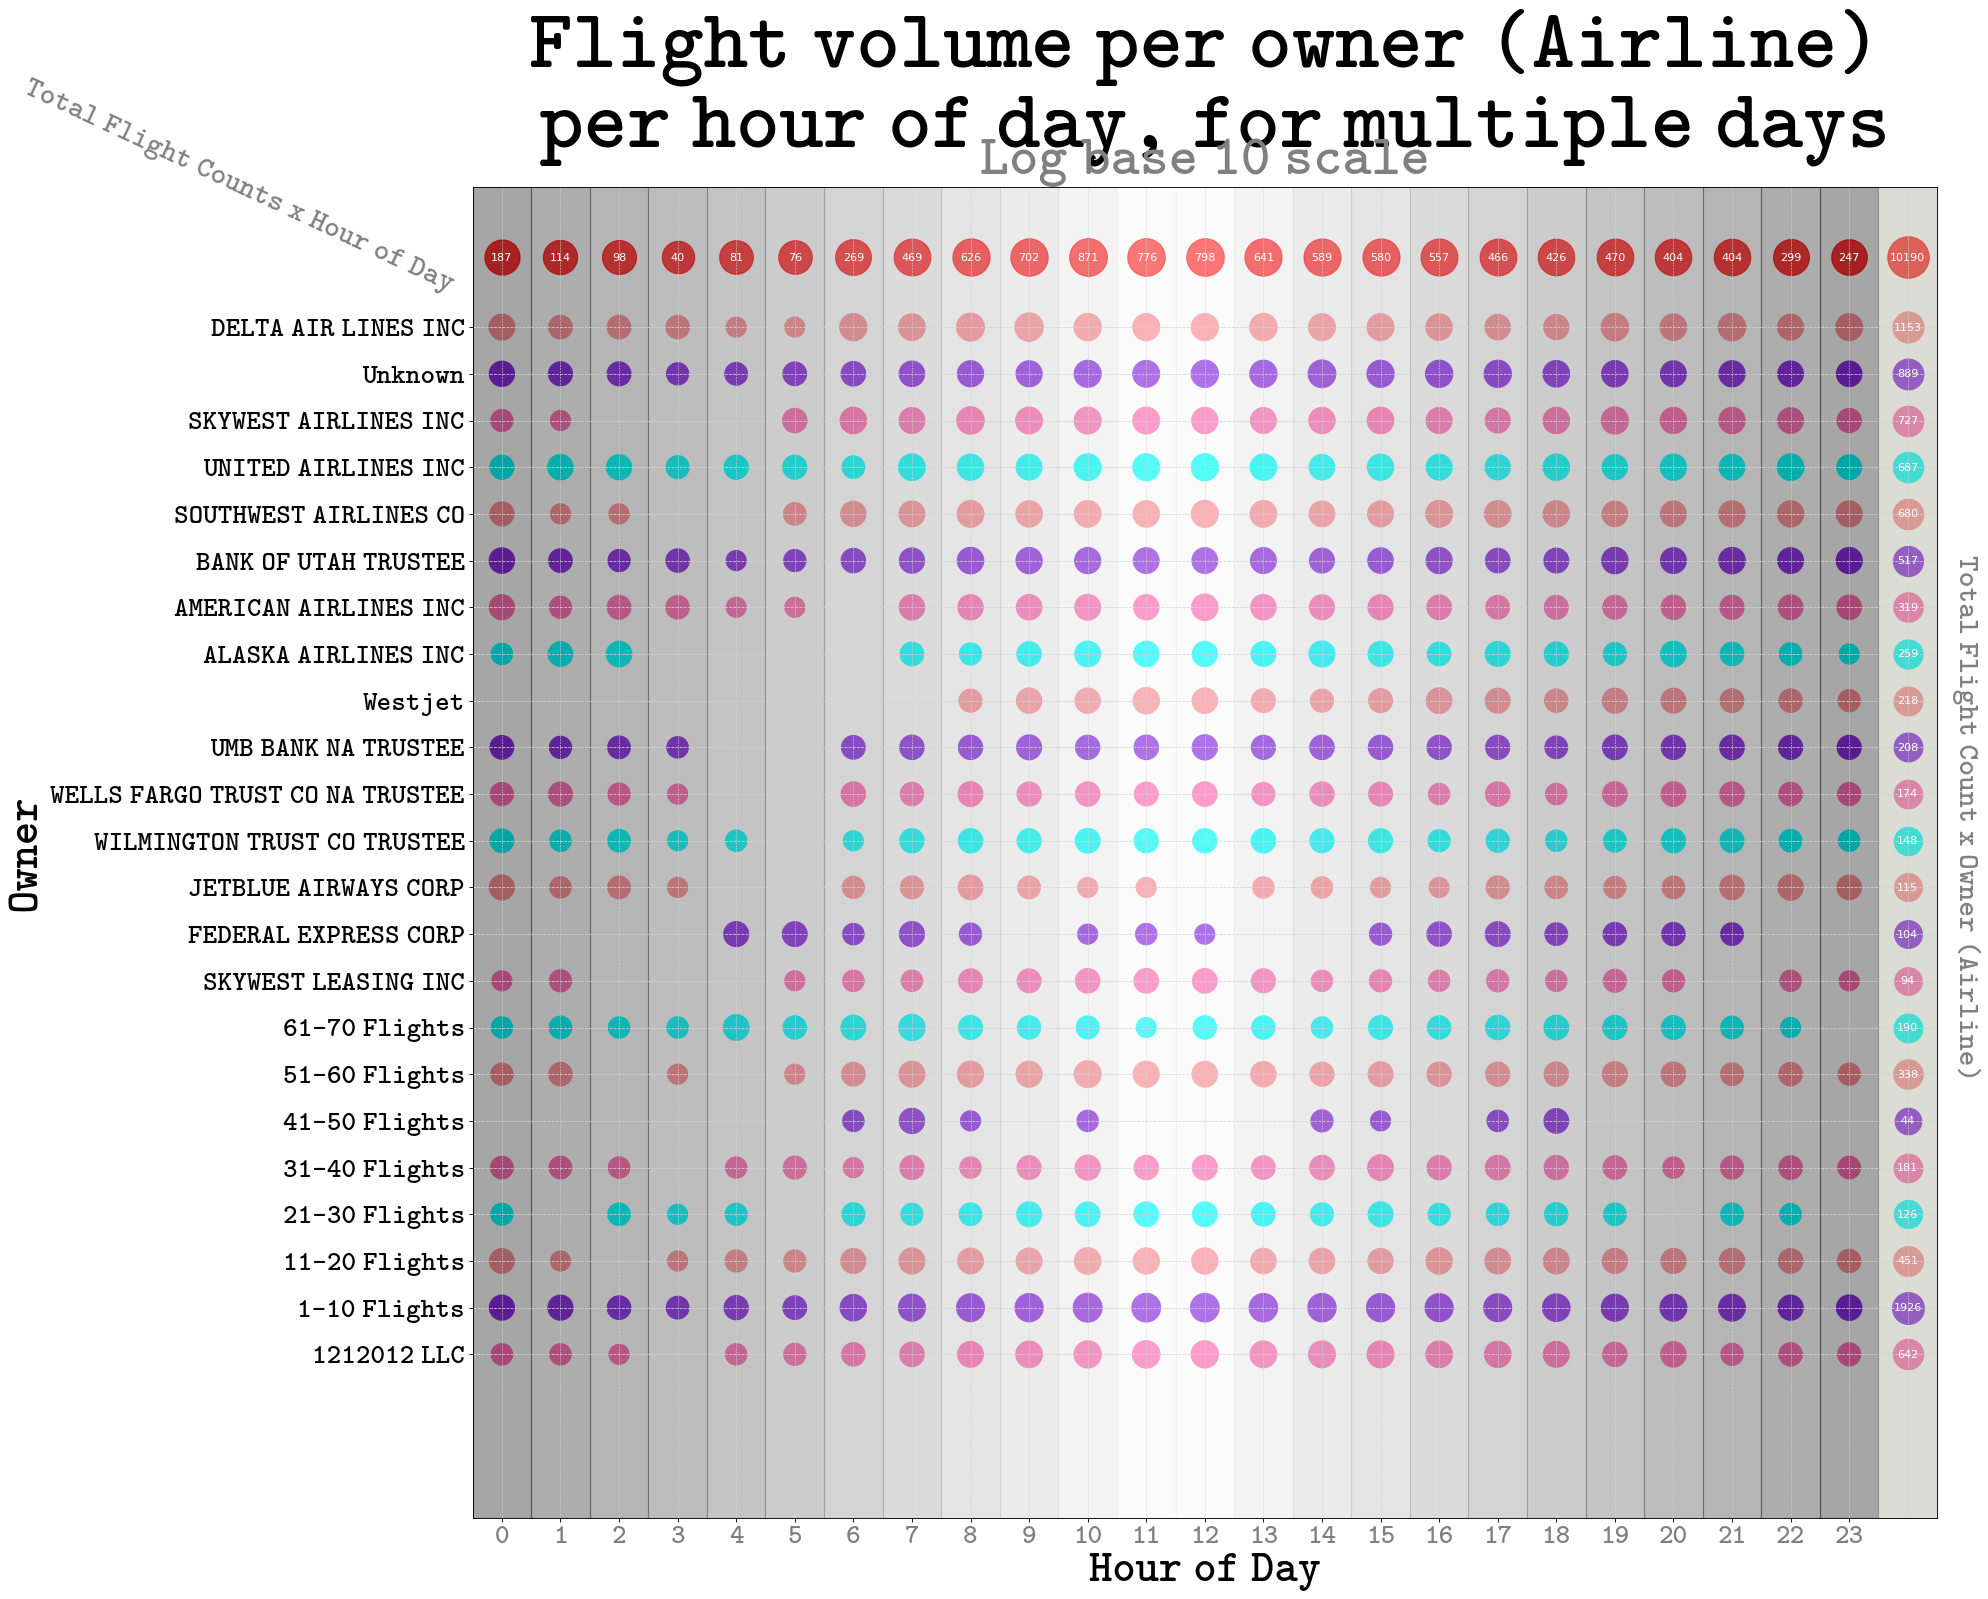

In [158]:
dp.time_scatterplot_circles(
    ksmt.GROUPED_DICT_10,
    ytick_spacing=1,
    multiplier=150,
    large_plot_title=False,
    FIGURE_Y_DIMENSIONS=20,
    FIGURE_X_DIMENSIONS=25,
    TICK_SIZE=25,
    GRAY_LABEL_SIZE=27,
    LABEL_SIZE=40,
    COUNT_SIZE=10,
    PADDING=2,
    FONTNAME='MathJax_Typewriter',
    SAVE_FILE='time_scatter_plot_10s.png'
)

/tmp/ipykernel_39238/1968760745.py:93: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hourly_counts_df = pd.DataFrame(columns=range(25), index=keys).fillna(0)  # Extend to include the extra column
/tmp/ipykernel_39238/1968760745.py:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(24, i * ytick_spacing, str(key_totals[i]), fontsize=COUNT_SIZE, color='white', ha='center', va='center')


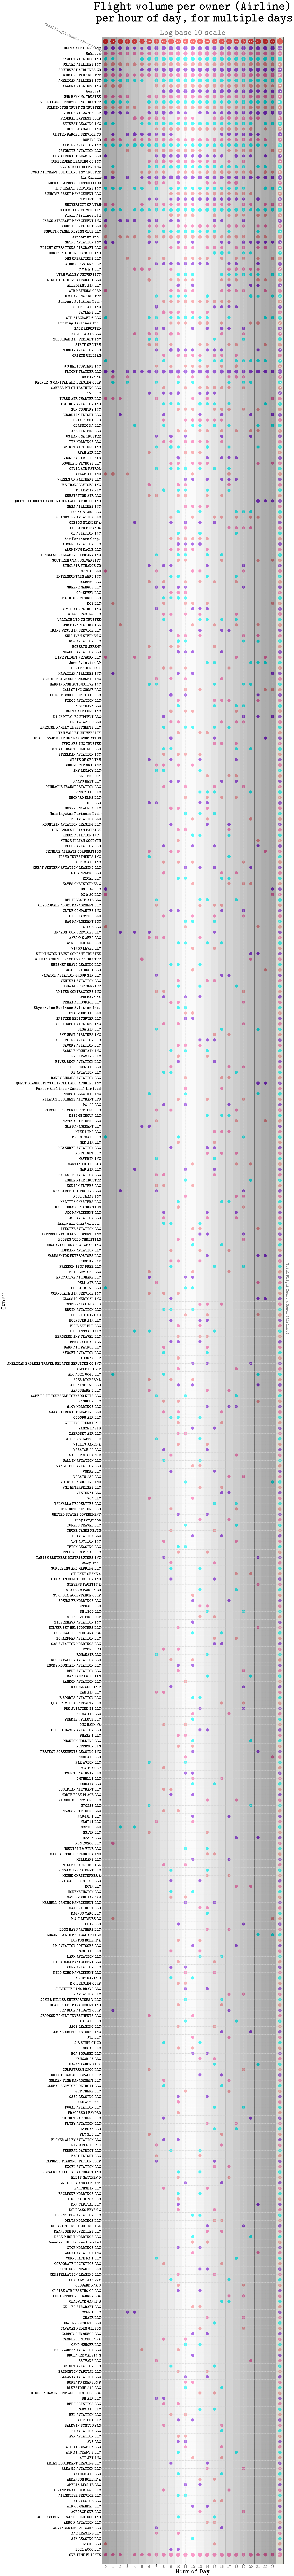

In [143]:
dp.time_scatterplot_circles(
    ksmt.GROUPED_DICT_SINGLE_FLIGHTS,
    ytick_spacing=2,
    multiplier=150,
    large_plot_title=True,
    FIGURE_Y_DIMENSIONS=220,
    FIGURE_X_DIMENSIONS=25,
    TICK_SIZE=25,
    GRAY_LABEL_SIZE=25,
    LABEL_SIZE=40,
    COUNT_SIZE=10,
    PADDING=9,
    FONTNAME='MathJax_Typewriter',
    SAVE_FILE='time_scatter_plot.png'
)

In [233]:
# dp.altitude_heatmap(
#     ksmt.FULL_ADSB_DICT,
#     extend=True,
#     FIGURE_Y_DIMENSIONS=10,
#     FIGURE_X_DIMENSIONS=30,
#     DPI=150,
#     marker_size=60,
#     marker_alpha=0.3,
#     MARKER_DAY_TIME = 'all',
#     zoom=10,
#     provider='stadia',
#     stadia_style="alidade_smooth_dark",
#     stadia_cache=False,
#     LEGEND_SIZE = 15, 
#     SAVE_FILE='altitude_heatmap_dark_all.png'
# )